In [2]:
from IPython.display import clear_output
# Install required packages.
#%%capture

!pip install torch-geometric
!pip install sentence_transformers

clear_output()

In [3]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import GCNConv, SAGEConv, to_hetero
import torch_geometric.transforms as T

In [4]:
dataset_path = '/tmp/'
dataset = MovieLens(root=dataset_path)

Extracting /tmp/raw/ml-latest-small.zip
Processing...


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Batches:   0%|          | 0/305 [00:00<?, ?it/s]

Done!


In [5]:
import numpy as np

In [6]:
dataset[0]

HeteroData(
  movie={ x=[9742, 404] },
  user={ num_nodes=610 },
  (user, rates, movie)={
    edge_index=[2, 100836],
    edge_label=[100836]
  }
)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = dataset[0].to(device)

In [8]:
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

In [9]:
data

HeteroData(
  movie={ x=[9742, 404] },
  user={ x=[610, 610] },
  (user, rates, movie)={
    edge_index=[2, 100836],
    edge_label=[100836]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100836] }
)

In [10]:
# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

In [11]:
weight = torch.bincount(train_data['user', 'rates','movie'].edge_label)
weight = weight.max() / weight

In [31]:
def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()


class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [32]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'rates','movie'].edge_label_index)
    target = train_data['user', 'rates','movie'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'rates','movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'rates','movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

lrs = [0.03, 0.02, 0.01, 0.002, 0.001, 0.0003]
n_channels = [16, 32, 64, 128]

A, B = np.meshgrid(lrs, n_channels)
pairs = list(zip(A.ravel(), B.ravel()))

best_params = (None, None)
best_rmse = 1e9
best_test = None

for lr, hidden_channels in pairs:
    print(f'{"="*40} lr = {lr} hidden_channels = {hidden_channels} {"="*40}')
    model = Model(hidden_channels=hidden_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, 301):
        loss = train()
        train_rmse = test(train_data)
        val_rmse = test(val_data)
        test_rmse = test(test_data)
        if epoch % 50 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
              f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_test = test_rmse
        best_params = (lr, hidden_channels)
    print()

======================================== lr = 0.03 hidden_channels = 16 ========================================
Epoch: 050, Loss: 3.4293, Train: 1.1327, Val: 1.1507, Test: 1.1555
Epoch: 100, Loss: 2.9704, Train: 1.1091, Val: 1.1696, Test: 1.1595
Epoch: 150, Loss: 2.8184, Train: 1.1058, Val: 1.1664, Test: 1.1623
Epoch: 200, Loss: 2.6874, Train: 1.0909, Val: 1.1427, Test: 1.1443
Epoch: 250, Loss: 2.5762, Train: 1.0802, Val: 1.1385, Test: 1.1421
Epoch: 300, Loss: 2.4272, Train: 1.0564, Val: 1.1249, Test: 1.1317

======================================== lr = 0.02 hidden_channels = 16 ========================================
Epoch: 050, Loss: 3.7901, Train: 1.2069, Val: 1.2074, Test: 1.2137
Epoch: 100, Loss: 3.2060, Train: 1.1313, Val: 1.1505, Test: 1.1478
Epoch: 150, Loss: 2.9548, Train: 1.1056, Val: 1.1469, Test: 1.1385
Epoch: 200, Loss: 2.7938, Train: 1.0929, Val: 1.1495, Test: 1.1402
Epoch: 250, Loss: 2.7025, Train: 1.0943, Val: 1.1578, Test: 1.1555
Epoch: 300, Loss: 2.6313, Train: 1.0

In [33]:
print('Best params:')
print(f'lr={best_params[0]}')
print(f'hidden_channels={best_params[1]}')
print(f'rmse on val: {best_rmse}')
print(f'rmse on test: {best_test}')

Best params:
lr=0.02
hidden_channels=32
rmse on val: 1.0641844272613525
rmse on test: 1.0613374710083008


## Задание

1) Подберите оптимальные параметры для сети из примера выше(2 балла)

2) Попробуйте вместо GraphSage модуль Graph Attention и также подберите оптимальные параметры  (2 балла)


**К идее Stage gnn добавляются attention коэффециенты $a_{i,j}$, которые вычисляются по следующим формулам**

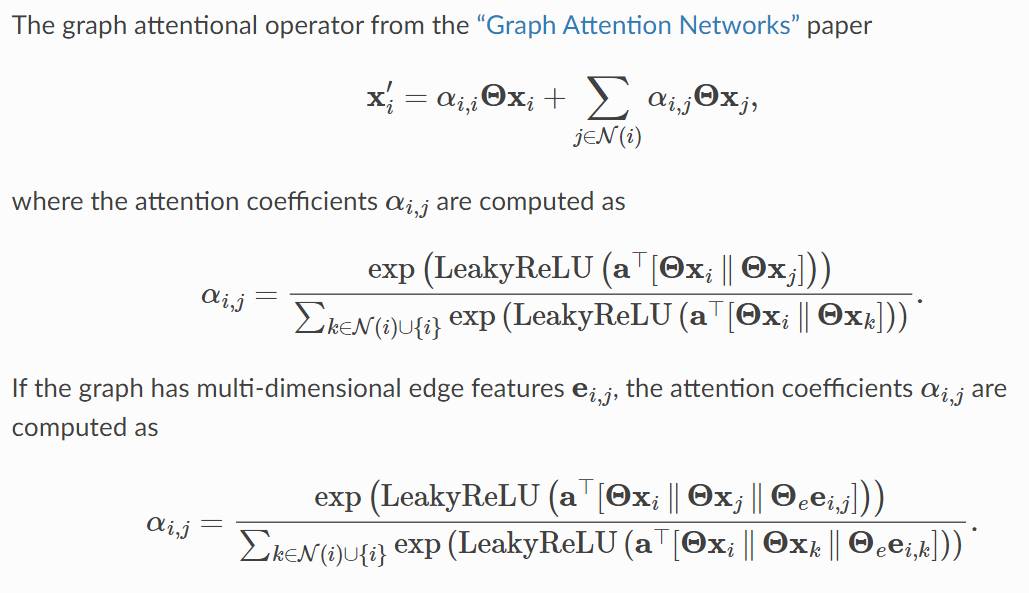

In [25]:
from torch_geometric.nn import GATConv

**В GATConv атрибут add_self_loops поставим False, иначе могут получиться неверные результаты message passing**

In [34]:
def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()


class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # Attention!!
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.conv2 = GATConv((-1, -1), out_channels, add_self_loops=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [35]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'rates','movie'].edge_label_index)
    target = train_data['user', 'rates','movie'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'rates','movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'rates','movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

lrs = [0.03, 0.02, 0.01, 0.002, 0.001, 0.0003]
n_channels = [16, 32, 64, 128]

A, B = np.meshgrid(lrs, n_channels)
pairs = list(zip(A.ravel(), B.ravel()))

best_params = (None, None)
best_rmse = 1e9
best_test = None

for lr, hidden_channels in pairs:
    print(f'{"="*40} lr = {lr} hidden_channels = {hidden_channels} {"="*40}')
    model = Model(hidden_channels=hidden_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, 301):
        loss = train()
        train_rmse = test(train_data)
        val_rmse = test(val_data)
        test_rmse = test(test_data)
        if epoch % 50 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
              f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_test = test_rmse
        best_params = (lr, hidden_channels)
    print()

======================================== lr = 0.03 hidden_channels = 16 ========================================
Epoch: 050, Loss: 4.8200, Train: 1.3140, Val: 1.3154, Test: 1.3086
Epoch: 100, Loss: 3.5597, Train: 1.1717, Val: 1.2124, Test: 1.1932
Epoch: 150, Loss: 3.3646, Train: 1.1091, Val: 1.1498, Test: 1.1391
Epoch: 200, Loss: 3.2373, Train: 1.1135, Val: 1.1461, Test: 1.1479
Epoch: 250, Loss: 3.1542, Train: 1.0856, Val: 1.1126, Test: 1.1199
Epoch: 300, Loss: 3.1235, Train: 1.1534, Val: 1.1704, Test: 1.2296

======================================== lr = 0.02 hidden_channels = 16 ========================================
Epoch: 050, Loss: 5.1414, Train: 1.3560, Val: 1.3829, Test: 1.3802
Epoch: 100, Loss: 3.6844, Train: 1.2147, Val: 1.2558, Test: 1.2045
Epoch: 150, Loss: 3.3904, Train: 1.1373, Val: 1.1825, Test: 1.1611
Epoch: 200, Loss: 3.2568, Train: 1.1106, Val: 1.1662, Test: 1.1544
Epoch: 250, Loss: 3.1126, Train: 1.1116, Val: 1.1767, Test: 1.1704
Epoch: 300, Loss: 3.0093, Train: 1.1

In [36]:
print('Best params:')
print(f'lr={best_params[0]}')
print(f'hidden_channels={best_params[1]}')
print(f'rmse on val: {best_rmse}')
print(f'rmse on test: {best_test}')

Best params:
lr=0.03
hidden_channels=32
rmse on val: 1.0682270526885986
rmse on test: 1.0609254837036133


**Из предыдущих опытов можем понять, что для графовых нейросетей, лучше работает lr побольше**